# Computational Essays on Artificial Intelligence
## Evolving Robot Controller for Coverage

In this essay, we explore the Genetic Algorithm to evolve a Robot control network.

1. A `chromosome` will be composed of a series of `genes`, each representing a weight in a neural network
2. A `population` of chromosomes is generated randomly
3. For a number of generations the chromosomes are `mutated` by a small amount

### 1. Setup

<div class="alert alert-block alert-info">
    <b>Note</b>: if running this notebook on Google Colab, you will need to install the required Python packages each time you start a session. Otherwise, you only need to install the packages once.
</div>

To install the required Python packages:

In [1]:
%pip install aitk --upgrade --quiet

Note: you may need to restart the kernel to use updated packages.


For this demonstration, we will need:

* `GeneticAlgorithm` defined in aitk.algorithms.ga
* `World`, `Scribbler`, `RangeSensor` from aitk.robots 
* `SimpleNetwork` from aitk.networks
* a few other support functions

We import everything need in this cell:

In [1]:
from aitk.algorithms.ga import GeneticAlgorithm
from aitk.robots import World, Scribbler, RangeSensor
from aitk.networks import SimpleNetwork
from aitk.robots.utils import distance
import random

## 2. The Genetic Algorithm

The [Genetic Algorithm](https://en.wikipedia.org/wiki/Genetic_algorithm) (GA) is an approach inside the category of machine learning systems called [Evolutionary Algorithms](https://en.wikipedia.org/wiki/Evolutionary_algorithm) (EA). For this essay, we will use the GA as follows:

1. We will define a `gene` to be a floating-point number that represents the weight or bias of a Neural Network.
2. We will define a `chromosome` as a sequence of genes. The chromosome (sometimes called a `geneotype`) will represent all of the weights and biases of a network.
3. A`population` will be composed of a set of random chromosomes.

The length of the chromosome is determined by the size of the Neural Network. Therefore, we will call `self.build_model()` (defined below) and see how many weights it has. 

We'll use a ring of 16 laser sensors as senses. We create a small simulated world (200 x 200) to allow the robot to move around.

The basic idea is that we will have a list of weights (the chromosome) that we load into the neural network. The sensors will be read, and propagated through the neural network. The output of the neural network will be interpreted as movement controls. We'll let the neural network "drive" the robot around the world starting from the center of the world.  

In [2]:
class NNGA(GeneticAlgorithm):
    """
    An example of using the GeneticAlgorithm class to 
    evolve the weights of a neural network to control 
    a simulated robot.
    """
    def __init__(self, popsize, sensors=16):
        self.show = False
        self.sensors = sensors
        self.world = World(200, 200)
        self.robot = Scribbler(x=100, y=100, a=87, 
                              max_trace_length=60)
        # We add a ring of RangeSensors, 8cm from
        # the robot center, starting and ending 
        # at the back of the robot
        # with 75cm max range, and sensor width 0
        # which makes it a laser range finder
        self.robot.add_device_ring(
            RangeSensor, 8, -180, 180, 
            self.sensors, max=100, width=0)
        self.world.add_robot(self.robot)
        self.network = self.build_model()
        # Length of a chromosome:
        length = len(self.network.get_weights(flat=True))
        super().__init__(length, popsize)

As mentioned, a chromosome will be a sequence of floating-point numbers, between -2 and +2. When we mutate such a gene, we will increase or decrease it a small amount. To define these two aspects of a gene, we define the following methods:

In [3]:
class NNGA(NNGA):        
    def make_random_gene(self):
        """
        Generate a random weight for the neural network.
        """
        # range of [-2, +2]
        return 2 - random.random() * 4
    
    def mutate_gene(self, gene):
        """
        Given a gene, mutate it a little.
        """
        # range of [-0.5, +0.5]
        return gene + (0.5 - random.random())

## 2.1 The Fitness Function

To use a GA we need to define a `fitness function`. A fitness function tests a chromosome in the simulated world, and returns a value that represents how "apt" (or fit) it is relative to the other chromosomes in the population at this generation.

Finding a good fitness function is difficult. We don't want to be too prescriptive, or the system will evolve exactly what we have defined it to do. On the other hand, we don't want to be too open, as that can leave the system to evolve solutions that don't really "solve a problem."

For example, let's say that we want the robot to move around this world and visit as much of the world as possible, like a vacuum cleaning robot.  We will need a way to keep track of where it has been.

In [4]:
from math import floor
from aitk.robots.colors import Color, WHITE

class Grid(object):
    """This class creates a grid of locations on top of a simulated world
    to monitor how much of the world has been visited. Each grid location
    is initally set to 0 to indicate that it is unvisited, and is updated
    by 1 every time that it is visited."""
    def __init__(self, grid_width, world):
        self.grid_width = grid_width
        self.world = world
        self.grid = []
        for i in range(self.grid_width):
            self.grid.append([0] * self.world.width)

    def show(self):
        """Print a representation of the grid."""
        for i in range(self.grid_width - 1, -1, -1):
            for j in range(self.grid_width):
                print("%3d" % self.grid[i][j], end=" ")
            print()
        print()
        
    def draw(self):
        """Impose a grid on the world to show visited cells."""
        self.world.canvas.clear()
        size = self.world.width // self.grid_width

        self.world.canvas.set_fill_style(Color(255, 255, 255, 100))
        self.world.canvas.set_stroke_style(WHITE)
        for x in range(self.world.width // size):
            self.world.canvas.draw_line(x * size, 0, x * size, self.world.height)
        for y in range(self.world.height // size):
            self.world.canvas.draw_line(0, y * size, self.world.width, y * size)
        
        for x in range(self.grid_width):
            for y in range(self.grid_width):
                value = self.grid[x][y]
                if value > 0:
                    row = self.grid_width - x - 1
                    self.world.canvas.draw_rect(
                        y * size, row * size, size, size)
        
    def update(self, x, y):
        """In the simulator, the origin is at the top-left corner.
        Update the appropriate grid location."""
        size = self.world.width/self.grid_width
        col = floor(x/size)
        row = int(self.grid_width) - floor(y/size) - 1
        self.grid[row][col] += 1
        
    def analyze_visits(self):
        """Calculate the percentage of visited cells in the grid."""
        cells_visited = 0
        for i in range(self.grid_width):
            for j in range(self.grid_width):
                if self.grid[i][j] > 0:
                    cells_visited += 1
        percent_visited = cells_visited/self.grid_width**2
        return percent_visited

### Picking an appropriate fitness function 

<div class="alert alert-block alert-warning">
    <b>Warning</b>: the implementation of a GA that we use here requires that the fitness function returns a number greater or equal to zero.
</div>

We will define the fitness function to be the percentage of grid locations visited (using the class defined above) during a 60 second run where the neural network is given the current sensor readings and outputs the translation and rotation commands for moving.

In [5]:
class NNGA(NNGA):        
    def fitness(self, chromosome, seconds=60, interrupt=True, real_time=False,
                show=False, show_progress=False, quiet=True):
        self.show = show
        self.network.set_weights(chromosome)
        self.robot.set_pose(100, 100, 87)
        self.grid = Grid(10, self.world)
        self.world.seconds(seconds, self.controller, interrupt=interrupt, 
                           real_time=real_time, show=show, show_progress=show_progress, 
                           quiet=quiet)
        score = self.grid.analyze_visits()
        return score

We can now add some methods for the specific problem:

* build_model - creates the neural network that takes as input the number of sensors, and outputs the movement commands (one for translate, one for rotate)
* controller - the method to drive the robot
* get_sensors - a convenience method to get the sensor readings from the range sensors as a list
* get_move - a method that takes the input to the network (the sensor readings) and propagates them through the network to get the output values, which are scaled to [-1, +1]

In [6]:
class NNGA(NNGA):        
    def build_model(self):
        """
        We build a simple network. 
        """
        return SimpleNetwork(
            self.sensors,
            4,
            2,
            activation="sigmoid"
        )
        
    def controller(self, world):
        """
        The controller for the robot.
        Updates the grid for visited locations.
        """
        sensors = self.get_sensors()
        output = self.get_move(sensors)
        self.robot.move(output[0], output[1])
        x, y, a = self.robot.get_pose()
        self.grid.update(x, y)
        self.grid.draw()
        if self.robot.stalled:
            return True
        
    def get_sensors(self):
        """
        We return the sensors from the robot.
        Make close readings be closer to 1.
        """
        return [1-sensor.get_reading() 
                for sensor in self.robot]
    
    def get_move(self, sensors):
        """
        Given the dataset (a single )
        """
        # Propagate takes a single pattern:
        output = self.network.propagate(
            sensors, show=self.show)
        # Scale the output in [-1, 1]
        return 1 - output * 2
    

Now, we are ready to create a GA. We'll define the population size to be 30, which isn't too small, but big enough to evolve a solution in a few minutes.

In [7]:
ga = NNGA(popsize=30)

Random seed set to: 8177350
Genetic algorithm
  Chromosome length: 78
  Population size: 30


We can observe the world with:

<div class="alert alert-block alert-success">
    <b>Idea</b>: when running in Jupyter Lab, you can right-click on the two watch cells (after running them) and select "Create New View for Output" for each. You can then drag the panels over so that you can see them along side the notebook.
</div>

In [8]:
ga.world.watch()

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x08\x06\x0…

We can also dynamically observe the network:

In [9]:
ga.network.watch()

HTML(value='<div style="outline: 5px solid #1976D2FF; width: 400px; height: 324px;"><svg id=\'keras-network\' …

## 2.2 Testing

Let's test everything to make sure it is working.

Let's see what a chromosome looks like:

In [10]:
len(ga.make_random_chromosome())

78

Therefore a chromome will be a length of 78 "genes". Each gene is an individual weight or bias in the neural network.

Let's see what the sensor readings look like:

In [11]:
sensors = ga.get_sensors()
sensors

[0.07862765400207938,
 0.008855006362971207,
 0.0,
 0.008855006362970985,
 0.07862765400207938,
 0.0,
 0.0,
 0.04472381958991678,
 0.06753487421199689,
 0.0,
 0.0,
 0.06753487421199733,
 0.04472381958991678,
 0.0,
 0.0,
 0.07862765400207938]

And let's see what movements the sensors give when propagated through the network and scaled:

In [12]:
ga.get_move(sensors)

array([-0.42732453,  0.08546025], dtype=float32)

You should see the activations in the network display change. The robot won't actually move in the simulator until we update it.

Ok, let's put all of this together and move the robot around the simulated world. We can test out a random chromosome to see what this does.

We pass in:

1. a random chromosome (like the that from the initial population)
2. number of seconds to run the simulation
4. whether we should show the robot and network updates
5. whether the simulation should run in real_time (setting to False will run as fast as possible)

Let's go!

In [13]:
ga.fitness(
    ga.make_random_chromosome(), 
    seconds=5,
    show=True, 
    real_time=True)

0.03

You can try the above cell over and over again to see many possible behaviors of these random weights.

Notice that there is a grid imposed on the world.  As the robot visits cells within this grid they light up. 

Some questions you might be interested in considering at this point?

1. What percentage of random genes spin in circles?
2. What percentage of random genes change movement during the 5 seconds of testing?
3. What is the range of "fitness" values returned for these random chromosomes?### 3. Evolve!

## 3. Evolving

To run 10 generations (plus one to test initial population) with a population of size 30 for 60 seconds each will take a significant amount of simulated time. 

We can get about a 50 x speed-up over real time when not watching the network, and about 10 x speed-up when watching the network.

You can run without watching by setting `show=False`.

In [15]:
%%time
ga.reset()
ga.world.reset()
bestFound = ga.evolve(
    generations=5, 
    crossover_rate=0.0, 
    mutation_rate=0.6, 
    elite_percent=0.05, 
    seconds=60,
    show=False,
) 

Using random seed: 8177350
  Maximum number of generations: 5
  Crossover rate: 0.0
  Mutation rate: 0.6
  Elite percentage: 0.05
  Elite count: 1
Generation    0 Best fitness 0.18
Generation    1 Best fitness 0.36
Generation    2 Best fitness 0.44
Generation    3 Best fitness 0.44
Generation    4 Best fitness 0.44
Generation    5 Best fitness 0.47
Max generations reached
CPU times: user 2min 16s, sys: 125 ms, total: 2min 16s
Wall time: 2min 16s


### 4. Analysis

We can see a summary of the best and average fitness in the population over time:

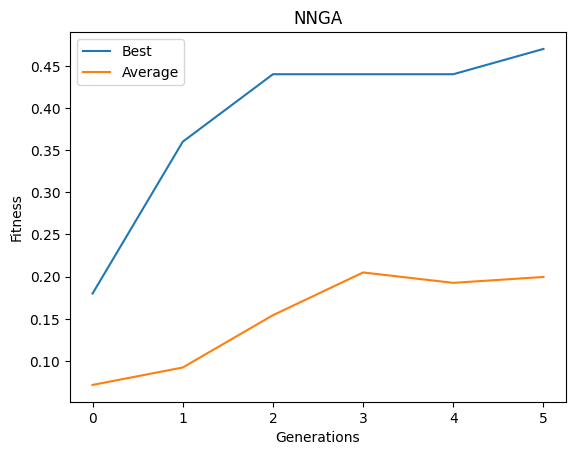

In [16]:
ga.plot_stats("NNGA")

Let's see the results by trying the best ever controller:

In [17]:
ga.fitness(
    ga.bestEver, 
    real_time=False, 
    show=True, 
    seconds=60,
)

0.47

In [18]:
ga.grid.show()

  0   0   0   0   0   0   0   0   0   0 
  0   6  12  13   2   5  11   7   0   0 
  0  12   8  12  32  20   0   7   7   0 
  0  12  10   0  35  10   6   0  12   0 
  0   7  22  13  20  15  25  20   2   0 
  0   2  12  11  23  12  24  14   0   0 
  0   5   6   0  13  13   0  11   0   0 
  0   0  12  11  20  16   0  15   0   0 
  0   0   0   0   0   5  12   0   0   0 
  0   0   0   0   0   0   0   0   0   0 



In [19]:
ga.network.save("nnga_best.h5")